In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_excel('original.xlsx', sheet_name='ROCDATA')
n=df.count()[0] #n=266

### Creating dataframes according to Test type and principal stresses

In [3]:
x_ucs=df[df['Test Type']=='UCS']['Sig3 (MPa)']
y_ucs=df[df['Test Type']=='UCS']['Sig1 (MPa)']
x_tcs=df[df['Test Type']=='TCS']['Sig3 (MPa)']
y_tcs=df[df['Test Type']=='TCS']['Sig1 (MPa)']
x_bts=df[df['Test Type']=='BTS']['Sig3 (MPa)']
y_bts=df[df['Test Type']=='BTS']['Sig1 (MPa)']

### Creating "sigma1_fit" column according to the HB non-linear regression

In [4]:
sigma_ci=75.66466459
mi=8.912147798

df['sigma1_fit']=df['Sig3 (MPa)']+sigma_ci*(mi*df['Sig3 (MPa)']/sigma_ci+1)**0.5
df['sigma1_fit'].fillna(0, inplace=True)

### RSS and SE

In [5]:
from scipy import stats

#Studnt, n=266, p<0.05, 2-tail
#equivalent to Excel TINV(0.05,10)
t=stats.t.ppf(1-0.025, n-2) # t=1.9689904969291439

In [6]:
sigma3=df['Sig3 (MPa)'].to_numpy()
sigma1=df['Sig1 (MPa)'].to_numpy()
sigma1_fit=df['sigma1_fit'].to_numpy()

# res: residual, norm_res: normalized residual
res=np.zeros(len(df.index), dtype='float')
norm_res=np.zeros(len(df.index), dtype='float')

for i in range(0,len(df.index)):
    if sigma3[i]<0 and sigma1[i]<5*np.absolute(sigma3[i]):
        res[i]=sigma3[i]-sigma1_fit[i]
        norm_res[i]=res[i]/sigma3[i]
    elif sigma3[i]<0 and sigma1[i]>5*np.absolute(sigma3[i]):
        res[i]=sigma1[i]-sigma1_fit[i]
        norm_res[i]=res[i]/sigma1_fit[i]
    elif sigma3[i]>=0:
        res[i]=sigma1[i]-sigma1_fit[i]
        norm_res[i]=res[i]/sigma1_fit[i]

In [7]:
# rss: residual sum of squares
rss=np.sum(np.square(res))

# se: standard error
# se=(rss/(n-2))^0.5
se=np.sqrt(rss/(n-2)) # se=20.212118936322643

### Prediciton Interval

In [8]:
pi_low=np.zeros(len(df.index), dtype='float')
pi_upp=np.zeros(len(df.index), dtype='float')

# rs: regression squares
mu_sigma3=np.full(n,sigma3.mean())
rs=(sigma3-mu_sigma3)**2
k=np.sqrt(1+1/n+rs/rs.sum())

for i in range(0,len(df.index)):
    if sigma3[i]<0 and sigma1[i]<5*np.absolute(sigma3[i]):
        pi_low[i]=sigma3[i]-t*se*k[i]
        pi_upp[i]=sigma3[i]+t*se*k[i]
    else:
        pi_low[i]=sigma1_fit[i]-t*se*k[i]
        pi_upp[i]=sigma1_fit[i]+t*se*k[i]

In [9]:
df['low_pi']=pd.DataFrame(pi_low)
df['upp_pi']=pd.DataFrame(pi_upp)

### Hoek-Brown Nonlinear regression plot

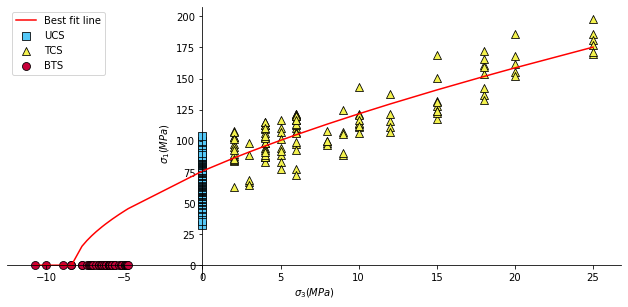

In [10]:
fig=plt.figure(figsize=(11,5))
plt.scatter(x_ucs, y_ucs, c='#55C8F7', marker='s', linewidths=.8, edgecolors='black', s=8**2, label='UCS')
plt.scatter(x_tcs, y_tcs, c='#F4F24E', marker='^', linewidths=.8, edgecolors='black', s=8**2, label='TCS')
plt.scatter(x_bts, y_bts, c='#C70039', marker='o', linewidths=.8, edgecolors='black', s=8**2, label='BTS')

df2 = df.sort_values(by ='Sig3 (MPa)')
plt.plot(df2['Sig3 (MPa)'], df2['sigma1_fit'], 'r-', label='Best fit line')

ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))

ax.set_xlabel(r"$\sigma_{3} (MPa)$")
ax.set_ylabel(r"$\sigma_{1} (MPa)$")
plt.legend()
plt.show()

### Hoek-Brown Prediction Intervals plot

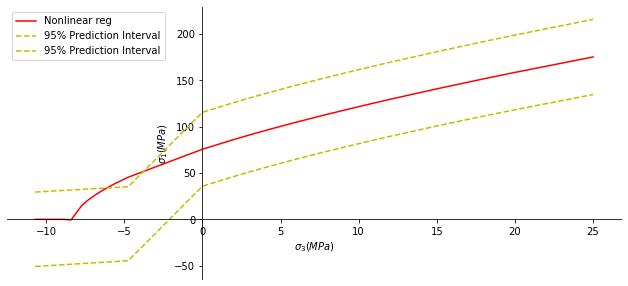

In [11]:
fig2=plt.figure(figsize=(11,5))

plt.plot(df2['Sig3 (MPa)'], df2['sigma1_fit'], 'r-', label='Nonlinear reg')
plt.plot(df2['Sig3 (MPa)'], df2['low_pi'], 'y--', label='95% Prediction Interval')
plt.plot(df2['Sig3 (MPa)'], df2['upp_pi'], 'y--', label='95% Prediction Interval')

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))

ax.set_xlabel(r"$\sigma_{3} (MPa)$")
ax.set_ylabel(r"$\sigma_{1} (MPa)$")
plt.legend()
plt.show()

### Exporting df to excel

In [12]:
df.to_excel('HoekBrown_bestfit.xlsx')